In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("experiments.jsonl", lines=True)
print(len(df))
df.head()

392


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,3ddffbe7f93b656485c8735c86e935dc825f48c7,worse-yolk,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,cte/excellent-format-few,cq,empty.json,...,0.017377,0.023292,0.027157,0.035213,0.006579,0.011827,0.007407,0.007956,CTE,0
1,10440a288bbffcf1b996a4ae93829166dc0d2f24,often-grot,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.0,cte/format-few,cq,empty.json,...,0.568887,0.692932,0.615815,0.742782,0.551316,0.695246,0.456790,0.534483,CTE,0
2,914c58822a6a22fe9562d07d6210aa038c68710d,sural-zoon,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.0,cte/excellent-format-few,cq,empty.json,...,0.540339,0.654402,0.580671,0.699737,0.538158,0.659919,0.419753,0.503899,CTE,0
3,99a285fedd0ce75fcf51b89c817d42bba44d7772,world-tads,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal,cq,empty.json,...,0.000000,0.000241,0.000000,0.000465,0.000000,0.000000,0.000000,0.000000,Standard,0
4,9ff91b866b34230fa372ecc1b0fcde14aeef726b,leaky-mako,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format,cq,empty.json,...,0.247000,0.349548,0.287540,0.400635,0.225000,0.332254,0.162963,0.224074,Standard,0


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [4]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [5]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples", "params.qa.temperature"])[
        "params.run"
    ]
    .aggregate(tuple)
    .reset_index()
)
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run
72,standard/excellent-few,cq,standard-2-shot.json,0.0,"(2, 3)"


## Statistical Testing

In [6]:
# Filter out experiments with F1 score < 0.1
df_filtered = df[df['metrics.f1'] >= 0.1].copy()
df_filtered.shape

(356, 15)

In [7]:
df_filtered

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,0.0,cot/excellent-format-reasoning,cq,empty.json,1,0.407944,0.489914,0.533546,0.625827,0.311842,0.377059,0.200000,0.281535,COT,0
1,0.0,cot/excellent-format-reasoning,cq,empty.json,2,0.407116,0.492792,0.527955,0.625286,0.310526,0.382631,0.214815,0.289931,COT,0
2,0.0,cot/excellent-format-reasoning,cq,empty.json,3,0.401738,0.489893,0.530351,0.627570,0.301316,0.377814,0.192593,0.274604,COT,0
3,0.1,cot/excellent-format-reasoning,cq,empty.json,1,0.409599,0.493538,0.535144,0.630265,0.306579,0.378292,0.214815,0.287126,COT,0
4,0.1,cot/excellent-format-reasoning,cq,empty.json,2,0.405048,0.490532,0.531949,0.629372,0.307895,0.374431,0.195062,0.279196,COT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,1.5,standard/minimal-output-format-fewest,cq,empty.json,2,0.527513,0.659429,0.585463,0.709983,0.517105,0.666309,0.367901,0.490239,Standard,0
388,1.5,standard/minimal-output-format-fewest,cq,empty.json,3,0.537029,0.661377,0.575080,0.701884,0.548684,0.677860,0.397531,0.505225,Standard,0
389,2.0,standard/minimal-output-format-fewest,cq,empty.json,1,0.271825,0.382596,0.313099,0.421900,0.260526,0.371239,0.165432,0.282405,Standard,0
390,2.0,standard/minimal-output-format-fewest,cq,empty.json,2,0.280099,0.371865,0.321885,0.418983,0.277632,0.375419,0.155556,0.219537,Standard,0


In [8]:
df_filtered['params.qa.system_prompt'].unique()

array(['cot/excellent-format-reasoning', 'cot/format-minimal',
       'cot/format-reasoning', 'cot/format-think',
       'cte/excellent-format-few', 'cte/excellent-format-fewest',
       'cte/format-few', 'cte/format-relevant-few',
       'standard/excellent-few', 'standard/excellent-fewest',
       'standard/helpful-output-format-few',
       'standard/minimal-output-format',
       'standard/minimal-output-format-few',
       'standard/minimal-output-format-few-no-prio',
       'standard/minimal-output-format-fewest'], dtype=object)

In [9]:
def prepare_data_for_anova(dataf, technique):
    metric_column='metrics.f1'
    
    # Filter data for the specified technique
    filtered_data = dataf[dataf['params.qa.technique'] == technique]

    if filtered_data.empty:
        raise ValueError(f"No data available for technique: {technique}")

    # Simplify column names for use in formula
    filtered_data = filtered_data.rename(columns={
        'params.qa.temperature': 'temperature',
        'params.qa.system_prompt': 'system_prompt',
        'params.qa.user_prompt_template': 'user_prompt',
        "params.qa.n_shot": "n_shot",
    })

    # Combine prompts into a single column for simplicity
    filtered_data['prompt'] = filtered_data['system_prompt'] + ' | ' + filtered_data['user_prompt'] + " | " + filtered_data['n_shot'].map(str)

    return filtered_data[['temperature', 'prompt', 'params.run', metric_column]].rename(columns={metric_column: 'f1'})

def two_way_anova(dataf):
    # Perform Two-Way ANOVA with replication
    formula = 'f1 ~ C(prompt) + C(temperature) + C(prompt):C(temperature)'
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)

def one_way_anova_by_temperature(dataf):
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf['temperature'].unique()
    for temp in temperatures:
        temp_data = dataf[dataf['temperature'] == temp]
        grouped = temp_data.groupby('prompt')['f1'].apply(list).reset_index()
        f1_scores = grouped['f1']

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp}:")
        print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")

def visualize_results(dataf):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='temperature', y='f1', hue='prompt', data=dataf)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    plt.legend(title="Prompt", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

prepared_data = prepare_data_for_anova(df_filtered, technique='Standard')


In [10]:
# Two-Way ANOVA
two_way_anova(prepared_data)

Two-Way ANOVA Results:
                            sum_sq     df             F         PR(>F)
C(prompt)                 0.013364    9.0    153.615238   1.880026e-33
C(temperature)            1.046056    7.0  15459.325999  3.411501e-163
C(prompt):C(temperature)  0.003127   63.0      5.134659   1.361138e-12
Residual                  0.001131  117.0           NaN            NaN


/home/baris/miniconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/home/baris/miniconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 5
  warnings.warn('covariance of constraints does not have full '
/home/baris/miniconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 63, but rank is 42
  warnings.warn('covariance of constraints does not have full '


In [11]:
# Perform One-Way ANOVA by Temperature
one_way_anova_by_temperature(prepared_data)

One-Way ANOVA for Temperature 0.0:
F-statistic: 1055.7724, p-value: 1.0526e-23
One-Way ANOVA for Temperature 0.1:
F-statistic: 329.0680, p-value: 3.0500e-14
One-Way ANOVA for Temperature 0.30000000000000004:
F-statistic: 242.9921, p-value: 2.4928e-13
One-Way ANOVA for Temperature 0.5:
F-statistic: 159.1387, p-value: 4.6175e-12
One-Way ANOVA for Temperature 0.7000000000000001:
F-statistic: 104.6674, p-value: 8.1227e-11
One-Way ANOVA for Temperature 1.0:
F-statistic: 65.8651, p-value: 1.8592e-09
One-Way ANOVA for Temperature 1.5:
F-statistic: 73.3054, p-value: 9.0608e-10
One-Way ANOVA for Temperature 2.0:
F-statistic: 8.8262, p-value: 4.2020e-04


In [12]:
# Tukey’s HSD
tukey = pairwise_tukeyhsd(endog=prepared_data['f1'], groups=prepared_data['prompt'], alpha=0.05)
print(tukey)


                                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                                             
                       group1                                              group2                       meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------------------------------------------------------------------------------
                    standard/excellent-few | cq | 0                     standard/excellent-few | cq | 2   0.0664 0.9974 -0.1816 0.3144  False
                    standard/excellent-few | cq | 0                  standard/excellent-fewest | cq | 0    -0.01    1.0 -0.1073 0.0873  False
                    standard/excellent-few | cq | 0                  standard/excellent-fewest | cq | 2   0.0602  0.995 -0.1461 0.2666  False
                    standard/excellent-few | cq | 0         standard/helpful-output-format-few | cq | 0   0.0112    1.0 -0.0861 0.1085  False
      

## Visualizations

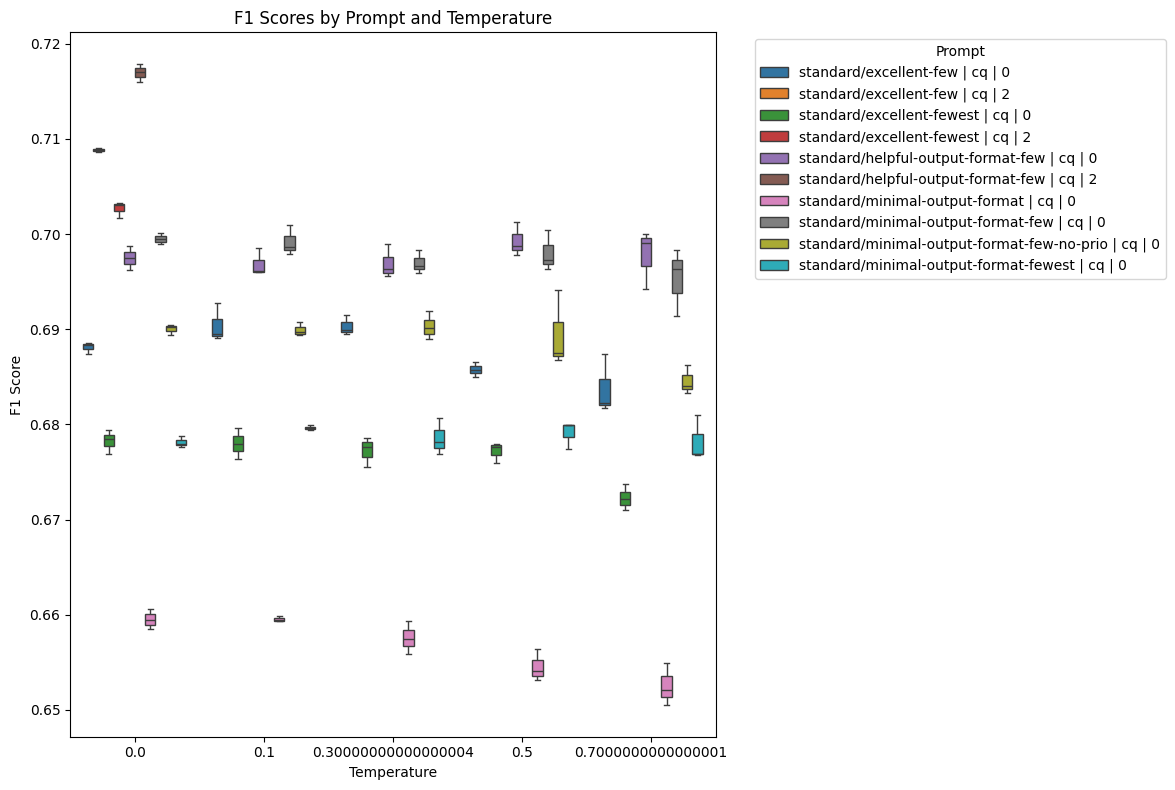

In [13]:
# Visualize Results
temperature_mask = prepared_data['temperature'] < 1.0
visualize_results(prepared_data.loc[temperature_mask])


In [14]:
def plot_variance(dataf, figsize=(8, 8), legend_loc='lower left'):
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='prompt', data=dataf, linewidth=2.5)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    plt.legend(title="Prompt", loc=legend_loc)
    plt.tight_layout()
    plt.show()

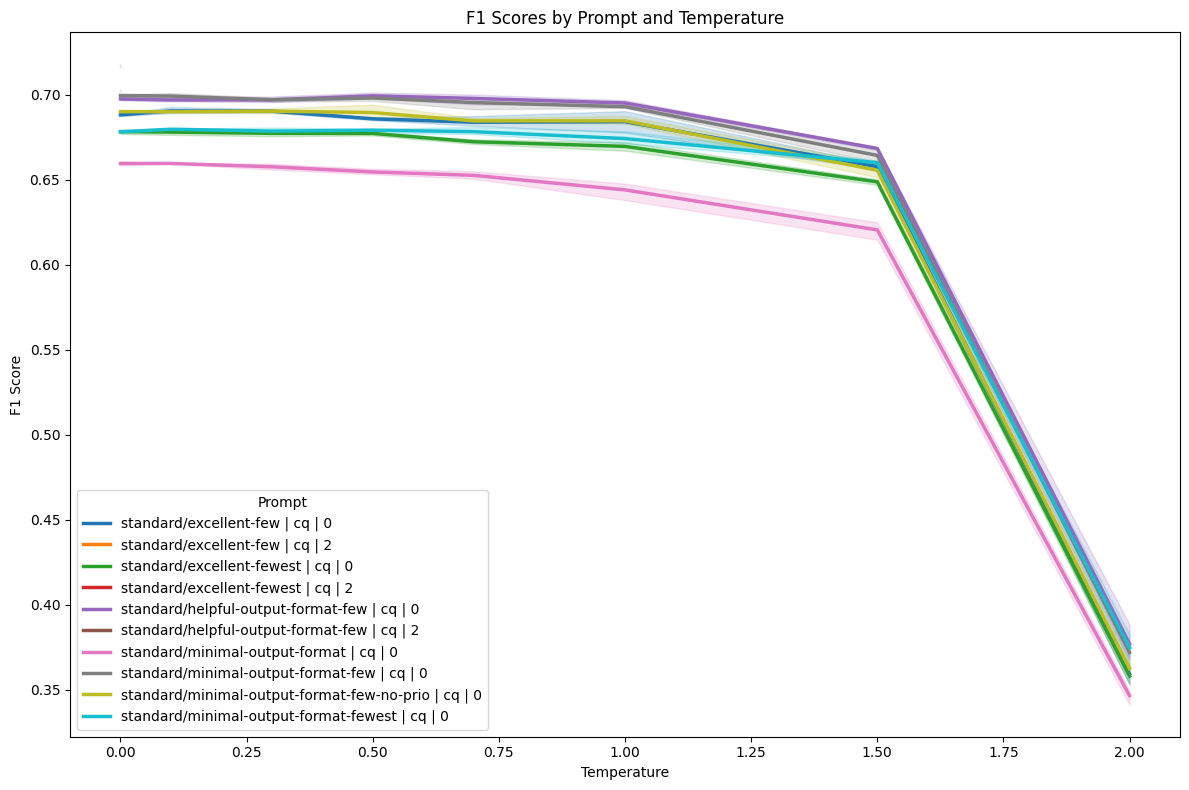

In [15]:
plot_variance(prepared_data, figsize=(12, 8))

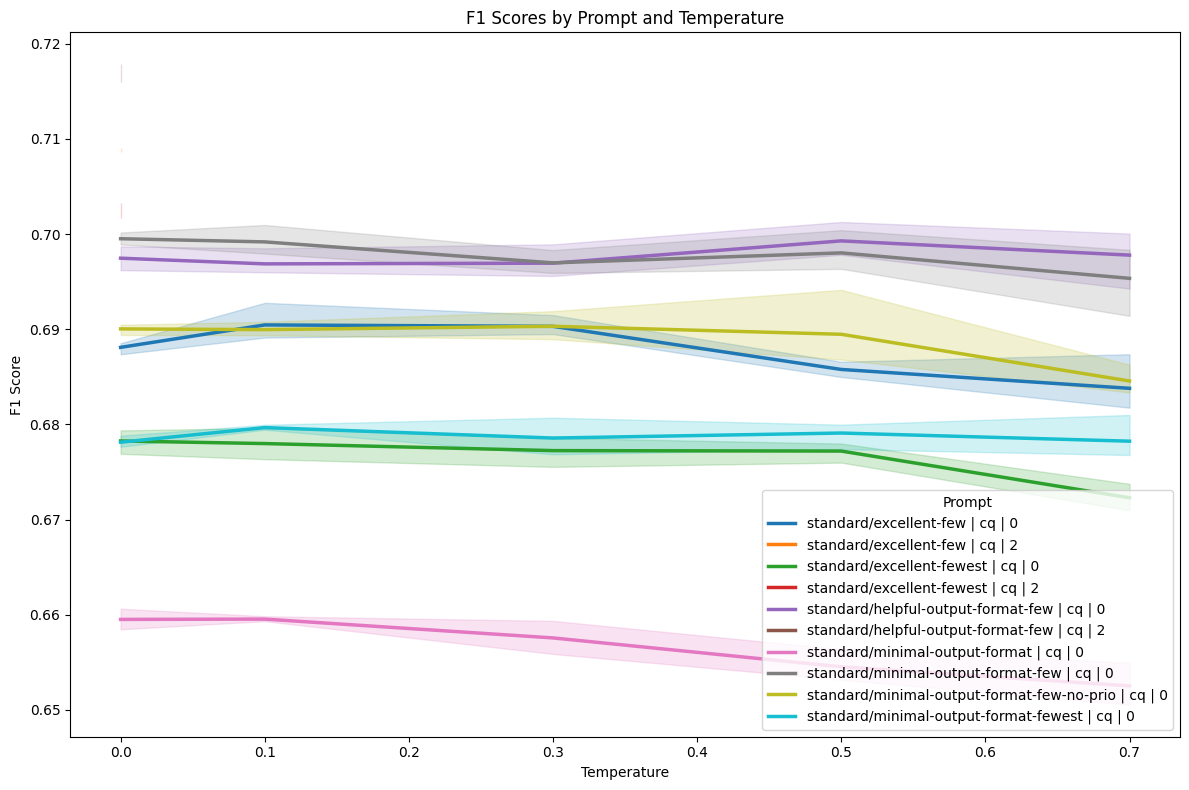

In [16]:
temperature_mask = prepared_data['temperature'] < 1.0
plot_variance(prepared_data.loc[temperature_mask], figsize=(12, 8), legend_loc='lower right')

In [17]:
temperature_mask = prepared_data["temperature"] <= 1.0
prompt_f1 = prepared_data.loc[temperature_mask].groupby(["prompt"])["f1"].describe()
prompt_f1.sort_values(by="mean", ascending=False, inplace=True)
prompt_f1

,count,mean,std,min,25%,50%,75%,max
prompt,,,,,,,,
standard/helpful-output-format-few | cq | 2,3.0,0.716935,0.000937,0.715956,0.716491,0.717026,0.717425,0.717824
standard/excellent-few | cq | 2,2.0,0.708834,0.000291,0.708629,0.708731,0.708834,0.708937,0.709040
standard/excellent-fewest | cq | 2,3.0,0.702657,0.000840,0.701692,0.702371,0.703051,0.703139,0.703228
standard/helpful-output-format-few | cq | 0,18.0,0.697238,0.002040,0.693941,0.696014,0.697103,0.698743,0.701265
standard/minimal-output-format-few | cq | 0,18.0,0.696987,0.002872,0.691406,0.696005,0.697628,0.698840,0.700948
standard/minimal-output-format-few-no-prio | cq | 0,18.0,0.688157,0.003178,0.682916,0.686408,0.689160,0.690201,0.694131
standard/excellent-few | cq | 0,18.0,0.687086,0.003792,0.677631,0.685176,0.687883,0.689483,0.692771
standard/minimal-output-format-fewest | cq | 0,18.0,0.677978,0.002544,0.671320,0.677053,0.678316,0.679829,0.680991
standard/excellent-fewest | cq | 0,18.0,0.675427,0.003657,0.667022,0.672549,0.676633,0.677988,0.679625


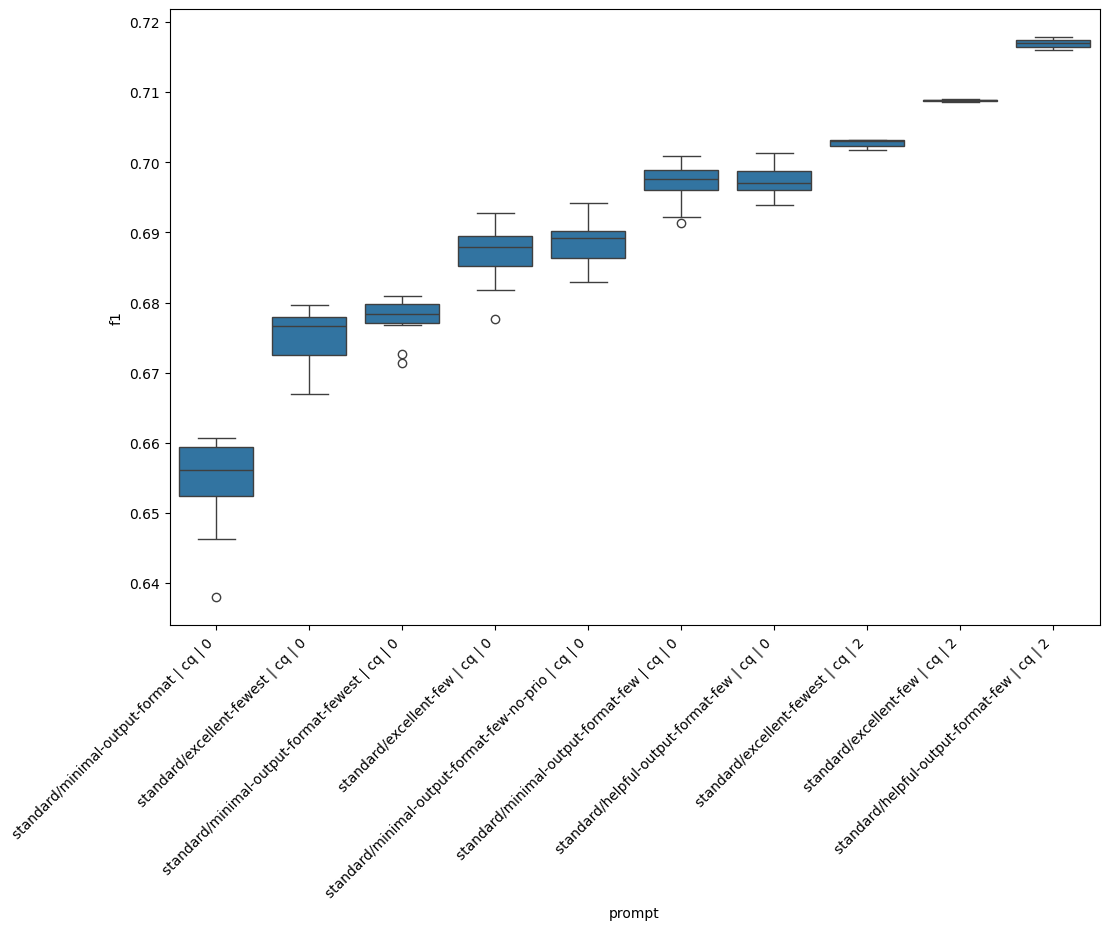

In [18]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_data.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=45, ha="right");